# Garbage Classification using keras and transfer learning

# **1. Data Acquisition**

# Import Libraries & Packages

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d mostafaabla/garbage-classification

 95% 227M/239M [00:01<00:00, 209MB/s]
100% 239M/239M [00:01<00:00, 166MB/s]


In [3]:
!unzip garbage-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: garbage_classification/paper/paper381.jpg  
  inflating: garbage_classification/paper/paper382.jpg  
  inflating: garbage_classification/paper/paper383.jpg  
  inflating: garbage_classification/paper/paper384.jpg  
  inflating: garbage_classification/paper/paper385.jpg  
  inflating: garbage_classification/paper/paper386.jpg  
  inflating: garbage_classification/paper/paper387.jpg  
  inflating: garbage_classification/paper/paper388.jpg  
  inflating: garbage_classification/paper/paper389.jpg  
  inflating: garbage_classification/paper/paper39.jpg  
  inflating: garbage_classification/paper/paper390.jpg  
  inflating: garbage_classification/paper/paper391.jpg  
  inflating: garbage_classification/paper/paper392.jpg  
  inflating: garbage_classification/paper/paper393.jpg  
  inflating: garbage_classification/paper/paper394.jpg  
  inflating: garbage_classification/paper/paper395.jpg  
  inflating: garbage_classification/pa

In [4]:
!pip install --upgrade tensorflow 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re
import cv2

from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print('setup successful!')

setup successful!


# **2. Data Visualization**

In [6]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 320    
IMAGE_HEIGHT = 320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "/content/garbage_classification/"

# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

print('defining constants successful!')

defining constants successful!


Membuat Dataframe

In [7]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df


filenames_list = []

categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  15515


In [8]:
df.head()

,filename,category
0,metal/metal308.jpg,3
1,clothes/clothes4997.jpg,7
2,clothes/clothes2305.jpg,7
3,white-glass/white-glass551.jpg,10
4,biological/biological635.jpg,11


shoes/shoes1248.jpg


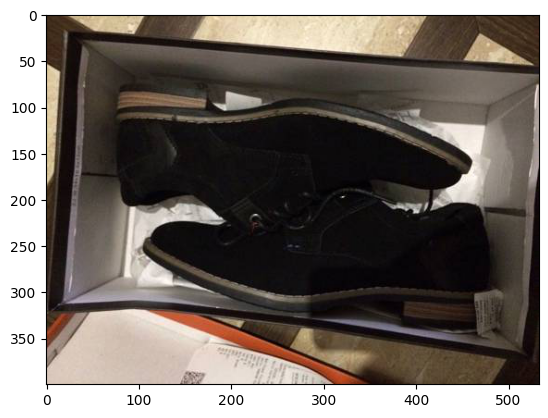

In [9]:
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

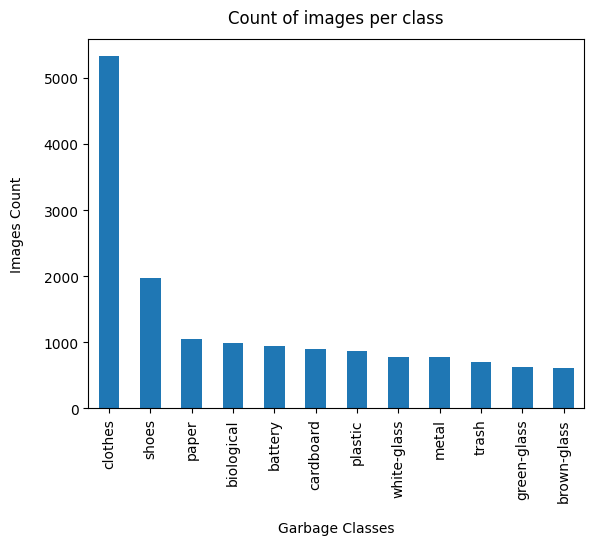

In [10]:
df_visualization = df.copy()

df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

# **3. Pre-Processing Data**

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.mobilenet_v2 as mobilenetv2

mobilenetv2_layer = mobilenetv2.MobileNetV2(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = 'imagenet')

# We don't want to train the imported weights
mobilenetv2_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def mobilenetv2_preprocessing(img):
  return mobilenetv2.preprocess_input(img)

model.add(Lambda(mobilenetv2_preprocessing))

model.add(mobilenetv2_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 320, 320, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 12)                15372     
                                                                 
Total params: 2,273,356
Trainable params: 15,372
Non-trainable params: 2,257,984
____________________________________________

In [12]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

print('call back defined!')

call back defined!


Split Dataset

In [13]:
df["category"] = df["category"].replace(categories) 

train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  1551 validate size =  1551 test size =  1552


In [14]:
batch_size=64

train_datagen = image.ImageDataGenerator(
    
    ###  Augmentation Start  ###
    
    #rotation_range=30,
    #shear_range=0.1,
    #zoom_range=0.3,
    #horizontal_flip=True,
    #vertical_flip = True,
    #width_shift_range=0.2,
    #height_shift_range=0.2
    
    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 12412 validated image filenames belonging to 12 classes.


In [15]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1551 validated image filenames belonging to 12 classes.


## 4. Training **Model**

In [16]:
epochs = 20
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=total_train//batch_size,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    callbacks=callbacks
)

Epoch 1/20
193/193 [==============================] - 94s 391ms/step - loss: 0.6135 - categorical_accuracy: 0.8375 - val_loss: 0.2828 - val_categorical_accuracy: 0.9284
Epoch 2/20
193/193 [==============================] - 76s 391ms/step - loss: 0.2450 - categorical_accuracy: 0.9325 - val_loss: 0.2122 - val_categorical_accuracy: 0.9440
Epoch 3/20
193/193 [==============================] - 82s 427ms/step - loss: 0.1842 - categorical_accuracy: 0.9495 - val_loss: 0.1910 - val_categorical_accuracy: 0.9434
Epoch 4/20
193/193 [==============================] - 74s 383ms/step - loss: 0.1526 - categorical_accuracy: 0.9571 - val_loss: 0.1846 - val_categorical_accuracy: 0.9401
Epoch 4: early stopping


In [28]:
model.save('garbage_classification_model.h5')

## **5. Evaluation and Validation Model**

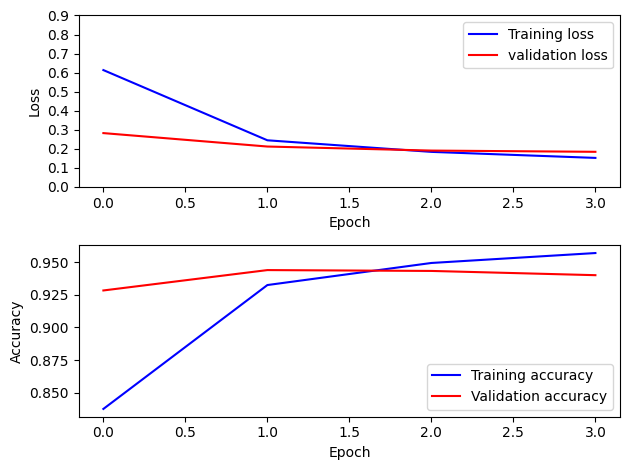

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()


ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [30]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 1552 validated image filenames belonging to 12 classes.


In [31]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('accuracy on test set = ',  round((accuracy * 100),2 ), '% ') 

<ipython-input-31-9a636182b474>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


accuracy on test set =  94.78 % 


In [32]:
gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


In [33]:
preds = model.predict_generator(test_generator, nb_samples)

preds = preds.argmax(1)

preds = [gen_label_map[item] for item in preds]

labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

<ipython-input-33-b92e1a6143ef>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, nb_samples)


              precision    recall  f1-score   support

     battery       0.96      0.95      0.95        78
  biological       0.97      0.98      0.98       115
 brown-glass       0.92      0.89      0.91        54
   cardboard       0.98      0.90      0.94        89
     clothes       0.98      0.99      0.99       500
 green-glass       0.96      0.92      0.94        86
       metal       0.88      0.86      0.87        78
       paper       0.92      0.97      0.94       115
     plastic       0.83      0.80      0.81        79
       shoes       0.96      0.97      0.97       218
       trash       0.87      0.95      0.91        65
 white-glass       0.89      0.88      0.89        75

    accuracy                           0.95      1552
   macro avg       0.93      0.92      0.92      1552
weighted avg       0.95      0.95      0.95      1552



## **6. Testing Model**

model.save_weights("garbage_classification_model.h5")

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),

In [36]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image

# Memuat model yang telah dilatih
model = keras.models.load_model('garbage_classification_model.h5')

# Path file gambar yang akan diprediksi
image_path = '/content/garbage_classification/battery/battery10.jpg'

# Mengubah gambar menjadi format yang dapat digunakan oleh model
img = image.load_img(image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Melakukan prediksi
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class]

# Menampilkan hasil prediksi
class_labels = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
predicted_label = class_labels[predicted_class]

print('Prediksi:', predicted_label)
print('Confidence:', confidence)


1/1 [==============================] - 1s 1s/step
Prediksi: battery
Confidence: 0.98185766


## **7. Deployment**